In [1]:
%pylab inline

from __future__ import (division, print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar

# AstroML
from astroML.plotting import hist

# Matplotlib related
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

# Personal
import hscUtils as hUtil
import galSBP
import coaddCutoutGalfitSimple as gSimple 

import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Absolute magnitude of sun in HSC filters

# Actuall borrowed from DES filters
# Values from magsun.data in FSPS
amag_sun_des_g = 5.08
amag_sun_des_r = 4.62
amag_sun_des_i = 4.52
amag_sun_des_z = 4.52
amag_sun_des_y = 4.51

# Based on http://www.baryons.org/ezgal/filters.php
amag_sun_ukiss_y = 4.515

# Extinction correction factor for HSC 
## A\_lambda = Coeff * E(B-V) 

a_hsc_g = 3.233
a_hsc_r = 2.291 
a_hsc_i = 1.635
a_hsc_z = 1.261
a_hsc_y = 1.076

# 
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

RSMA_COMMON = np.arange(0.4, 4.2, 0.02)

In [22]:
# Code for Get Bootstrap mean or median 
def _confidence_interval_1d(A, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    """Calculates bootstrap confidence interval along one dimensional array"""
    
    if not isinstance(alpha, collections.Iterable):
        alpha = np.array([alpha])

    N = len(A)
    resampleInds = np.random.randint(0, N, (numResamples,N))
    metricOfResampled = metric(A[resampleInds], axis=-1)

    confidenceInterval = np.zeros(2*len(alpha),dtype='float')
    
    if interpolate:
        for thisAlphaInd, thisAlpha in enumerate(alpha):
            confidenceInterval[2*thisAlphaInd] = scoreatpercentile(metricOfResampled, 
                                                                   thisAlpha*100/2.0)
            confidenceInterval[2*thisAlphaInd+1] = scoreatpercentile(metricOfResampled, 
                                                                     100-thisAlpha*100/2.0)
    else:
        sortedMetricOfResampled = np.sort(metricOfResampled)
        for thisAlphaInd, thisAlpha in enumerate(alpha):
            confidenceInterval[2*thisAlphaInd] = sortedMetricOfResampled[int(round(thisAlpha*numResamples/2.0))]
            confidenceInterval[2*thisAlphaInd+1] = sortedMetricOfResampled[int(round(numResamples - 
                                                                                     thisAlpha*numResamples/2.0))]
    return confidenceInterval
    
def _ma_confidence_interval_1d(A, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    A = np.ma.masked_invalid(A, copy=True)
    A = A.compressed()
    confidenceInterval = _confidence_interval_1d(A, alpha, metric, numResamples, interpolate)
    return confidenceInterval

def confidence_interval(A, axis=None, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    """Return the bootstrap confidence interval of an array or along an axis ignoring NaNs and masked elements.
    
    Parameters
    ----------
    A : array_like
        Array containing numbers whose confidence interval is desired. 
    axis : int, optional
        Axis along which the confidence interval is computed.
        The default is to compute the confidence interval of the flattened array.
    alpha: float or array, optional
        confidence level of confidence interval. 100.0*(1-alpha) percent confidence 
        interval will be returned.
        If length-n array, n confidence intervals will be computed
        The default is .05
    metric : numpy function, optional
        metric to calculate confidence interval for.
        The default is numpy.mean
    numResamples : int, optional
        number of bootstrap samples. The default is 10000.
    interpolate: bool, optional
        uses scipy.stats.scoreatpercentile to interpolate between bootstrap samples 
        if alpha*numResamples/2.0 is not integer.
        The default is True
        
    Returns
    -------
    confidenceInterval : ndarray
    An array with the same shape as `A`, with the specified axis replaced by one twice the length of the alpha
    If `A` is a 0-d array, or if axis is None, a length-2 ndarray is returned.
    """
    if interpolate is True and scoreatpercentile is False:
        print("need scipy to interpolate between values")
        interpolate = False
    A = A.copy()
    if axis is None:
        A = A.ravel()
        outA = _ma_confidence_interval_1d(A, alpha, metric, numResamples, interpolate)
    else:
        outA = np.apply_along_axis(_ma_confidence_interval_1d, axis, A, alpha, 
                                   metric, numResamples, interpolate)
        
    return outA

def normProf(sma, sbp, minSma, maxSma, divide=False): 
    """
    Naive method to normalize the profile. 
    
    Parameters: 
        sbp    : Array for surface brightness profile 
        sma    : Radius range 
        minSma : Minimum SMA
        maxSma   Maximum SMA
    """
    offset = np.nanmedian(sbp[(sma >= minSma) & 
                              (sma <= maxSma)])
    if divide: 
        return (sbp / offset)
    else:
        return (sbp-offset)
    
    
def pixKpc(redshift, pix=0.168, show=True, npix=1.0):
    """
    Get the corresponding Kpc size of a pixel.  
    
    Parameters: 
    """
    pixKpc = pix * npix * hUtil.cosmoScale(redshift)

    if show:
        print("# %d pixel(s) = %6.3f Kpc" % (npix, pixKpc))
        
    return pixKpc


def logAdd(para1, para2):
    """ Useful for adding magnitudes. """
    return np.log10((10.0 ** np.asarray(para1)) + 
                    (10.0 ** np.asarray(para2)))


def errAdd(err1, err2):
    """Add error quadral..."""
    return np.sqrt((err1 ** 2.0) + 
                   (err2 ** 2.0))


def toColorArr(data, bottom=None, top=None):
    """ 
    Convert a data array to "color array" (between 0 and 1). 
    
    Parameters:
        bottom, top  : 
    """
    if top is not None:
        data[data >= top] = top
    if bottom is not None:
        data[data <= bottom] = bottom
        
    return ((data - np.nanmin(data)) / 
            (np.nanmax(data) - np.nanmin(data))) * 255.0


def getLuminosity(mag, redshift, extinction=None, 
                  amag_sun=None):
    """Get the absolute magnitude or luminosity."""
    distmod = hUtil.cosmoDistMod(redshift)
    absMag = (mag - distmod)
    if extinction is not None: 
        absMag -= extinction 
    if amag_sun is not None: 
        absMag = ((amag_sun - absMag) / 2.5)
    
    return absMag

def getStackProfiles(sample, loc, name='GAMA', 
                     idCol='ID_USE', tabCol='sum_tab', save=True):
    """Get the stacks of the profiles."""
    print("## Sample %s : Will deal with %d galaxies" % (name, len(sample)))
    profiles = []
    with ProgressBar(len(sample), ipython_widget=True) as bar:
        for g in sample:
            try:
                gFile = os.path.join(loc, g['sum_tab'].replace('./', '')).strip()
                gProf = Table.read(gFile, format='fits')
                """ Add extra information """
                try: 
                    gProf.meta['KCORRECT_I'] = g['KCORRECT_I']
                    gProf.meta['KCORRECT_b_I'] = g['KCORRECT_b_I']
                    gProf.meta['KCORRECT_c_I'] = g['KCORRECT_c_I']
                    gProf.meta['KCORRECT_G'] = g['KCORRECT_G']
                    gProf.meta['KCORRECT_b_G'] = g['KCORRECT_b_G']
                    gProf.meta['KCORRECT_c_G'] = g['KCORRECT_c_G']
                    gProf.meta['KCORRECT_R'] = g['KCORRECT_R']
                    gProf.meta['KCORRECT_b_R'] = g['KCORRECT_b_R']
                    gProf.meta['KCORRECT_c_R'] = g['KCORRECT_c_R']
                    gProf.meta['KCORRECT_Z'] = g['KCORRECT_Z']
                    gProf.meta['KCORRECT_b_Z'] = g['KCORRECT_b_Z']
                    gProf.meta['KCORRECT_c_Z'] = g['KCORRECT_c_Z']
                    gProf.meta['KCORRECT_Y'] = g['KCORRECT_Y']
                    gProf.meta['KCORRECT_b_Y'] = g['KCORRECT_b_Y']
                    gProf.meta['KCORRECT_c_Y'] = g['KCORRECT_c_Y']
                    gProf.meta['LOGM2LI_A'] = g['logm2lI_A']
                    gProf.meta['LOGM2LI_B'] = g['logm2lI_B']
                    gProf.meta['LOGM2LI_C'] = g['logm2lI_C']
                    gProf.meta['LUM_100'] = g['lum_100']
                    gProf.meta['LUM_120'] = g['lum_120']
                except Exception:
                    print("## WARNING: Some metadata may not be available !")
                    continue
            except Exception:
                print("## Missing: %s" % gFile)
                continue 
            profiles.append(gProf)
            bar.update()
    
    if save: 
        outPkl = os.path.join(loc, (name + '_profs.pkl'))
        hUtil.saveToPickle(profiles, outPkl)
        print("## Save %s to %s" % (name, outPkl))
        
    return profiles


def organizeSbp(profiles, col1='muI1', col2='KCORRECT_c_I', 
                kind='sbp', norm=False, r1=9.9, r2=10.1, divide=False,
                col3=None, col4=None, justStack=False,
                sun1=amag_sun_des_g, sun2=amag_sun_des_r):
    """ Get the stack of individual profiels, and their med/avg. """
    if kind.strip() == 'sbp':
        if col2 is not None: 
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(p[col1] + (p.meta[col2] / 2.5)), 
                                           r1, r2, divide=divide) 
                                  for p in profiles)
            else:
                stack = np.vstack(np.asarray(p[col1] + (p.meta[col2] / 2.5)) 
                                  for p in profiles)
        else: 
            print("## NO KCORRECTION APPLIED !!")            
            if norm:
                stack = np.vstack(normProf(p['rKpc'], p[col1], 
                                           r1, r2, divide=divide) 
                                  for p in profiles)
            else:
                stack = np.vstack(np.asarray(p[col1]) for p in profiles)
    elif kind.strip() == 'mass':
        if norm:
            stack = np.vstack(normProf(p['rKpc'], 
                                       np.asarray(p[col1] + p.meta[col2]), 
                                       r1, r2, divide=divide) for p in profiles)
        else: 
            stack = np.vstack(np.asarray(p[col1] + p.meta[col2]) for p in profiles)
    elif kind.strip() == 'color':
        cSun = (sun1 - sun2)
        if col3 is None or col4 is None:
            print("## NO KCORRECTION APPLIED !!")
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(cSun - 2.5 * (p[col1] - p[col2])), 
                                           r1, r2, divide=divide) for p in profiles)
            else: 
                stack = np.vstack(np.asarray(cSun - 2.5 *(p[col1] - p[col2])) for p in profiles)
        else:
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(cSun - 2.5 * (p[col1] - p[col2]) -
                                                      (p.meta[col3] - p.meta[col4])), 
                                           r1, r2, divide=divide) for p in profiles)
            else: 
                stack = np.vstack(np.asarray(cSun - 2.5 * (p[col1] - p[col2]) -
                                             (p.meta[col3] - p.meta[col4])) 
                                  for p in profiles)
    elif kind.strip() == 'lum':
        if col2 is None:
            stack = np.vstack(np.asarray(p[col1]) for p in profiles)
        else:
            stack = np.vstack(np.asarray(p[col1] - p.meta[col2]) for p in profiles)
    else: 
        raise Exception("## WRONG KIND !!")
        
    if not justStack:
        """ Get the median and 1-sigma confidence range """
        medProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanmedian, numResamples=1000, 
                                      interpolate=True) 
        avgProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanmean, numResamples=1000, 
                                      interpolate=True) 
        stdProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanstd, numResamples=1000, 
                                      interpolate=True) 
        return stack, medProf, avgProf, stdProf
    else: 
        return stack
    

def loadPkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None

In [23]:
newDir = '/Users/songhuang/work/hscs/gama_massive/sbp/'

bcgFile = 'redbcg_1d_160211.fits'
memFile = 'redmem_1d_160211.fits'
gamaFile = 'gama_1d_160211.fits'

try:
    bcgTab
except NameError:
    pass
else:
    del bcgTab
    
try:
    memTab
except NameError:
    pass
else:
    del memTab    
    
try:
    gamaTab
except NameError:
    pass
else:
    del gamaTab

# Two summary catalogs
bcgCat = os.path.join(newDir, bcgFile)
memCat = os.path.join(newDir, memFile)
gamaCat = os.path.join(newDir, gamaFile)

if not os.path.isfile(bcgCat):
    raise Exception("## Can not find catalog for BCGs : %s" % bcgCat)
else: 
    bcgTab = Table.read(bcgCat, format='fits')

if not os.path.isfile(memCat):
    raise Exception("## Can not find catalog for cluster members : %s" % memCat)
else: 
    memTab = Table.read(memCat, format='fits')
    
if not os.path.isfile(gamaCat):
    raise Exception("## Can not find catalog for GAMA galaxies : %s" % gamaCat)
else: 
    gamaTab = Table.read(gamaCat, format='fits')
    
print("## Deal with %i galaxies in redBCH sample" % len(bcgTab))
print("## Deal with %i galaxies in redMEM sample" % len(memTab))
print("## Deal with %i galaxies in GAMA sample" % len(gamaTab))

## Deal with 219 galaxies in redBCH sample
## Deal with 1670 galaxies in redMEM sample
## Deal with 11053 galaxies in GAMA sample


In [24]:
def doubleSchechter(logm, logm0=10.91, 
                    logphi1=-2.97, logphi2=-2.79, 
                    alpha1=-0.46, alpha2=-1.58):
    
    phi1 = (10.0 ** logphi1)
    phi2 = (10.0 ** logphi2)
    dlogm = (logm - logm0)
    
    term1 = np.log(10.0) * np.exp(-1.0 * (10.0 ** dlogm))
    term2 = phi1 * (10.0 ** ((alpha1 + 1.0) * dlogm))
    term3 = phi2 * (10.0 ** ((alpha2 + 1.0) * dlogm))
    
    return term1 * (term2 + term3)

# Luminosity Function of Massive Galaxies

In [25]:
lfB12 = Table.read('iband-lf-B12.txt', format='ascii')

In [26]:
area1 = 60.0
area2 = 90.0

# 0.15 < z < 0.40
gamaZ1 = gamaTab[(gamaTab['Z'] >= 0.15) & (gamaTab['Z'] <= 0.4)]
bcgZ1 = bcgTab[(bcgTab['Z'] >= 0.15) & (bcgTab['Z'] <= 0.4) & (bcgTab['P_CEN_1'] > 0.8)]

dGama1 = (c.V(np.nanmin(gamaZ1['Z']), np.nanmax(gamaZ1['Z'])) / ((360.0 ** 2.0) / np.pi)) * area1
dBcg1 = (c.V(np.nanmin(bcgZ1['Z']), np.nanmax(bcgZ1['Z'])) / ((360.0 ** 2.0) / np.pi)) * area2

# 0.15 < z < 0.55
gamaZ2 = gamaTab[(gamaTab['Z'] >= 0.15) & (gamaTab['Z'] <= 0.55)]
bcgZ2 = bcgTab[(bcgTab['Z'] >= 0.15) & (bcgTab['Z'] <= 0.55) & (bcgTab['P_CEN_1'] > 0.8)]

dGama2 = (c.V(np.nanmin(gamaZ2['Z']), np.nanmax(gamaZ2['Z'])) / ((360.0 ** 2.0) / np.pi)) * area1
dBcg2 = (c.V(np.nanmin(bcgZ2['Z']), np.nanmax(bcgZ2['Z'])) / ((360.0 ** 2.0) / np.pi)) * area2

print(dGama1, dBcg1)
print(dGama2, dBcg2)

21278281.5494 31048272.1688
39586533.8559 72576538.2831


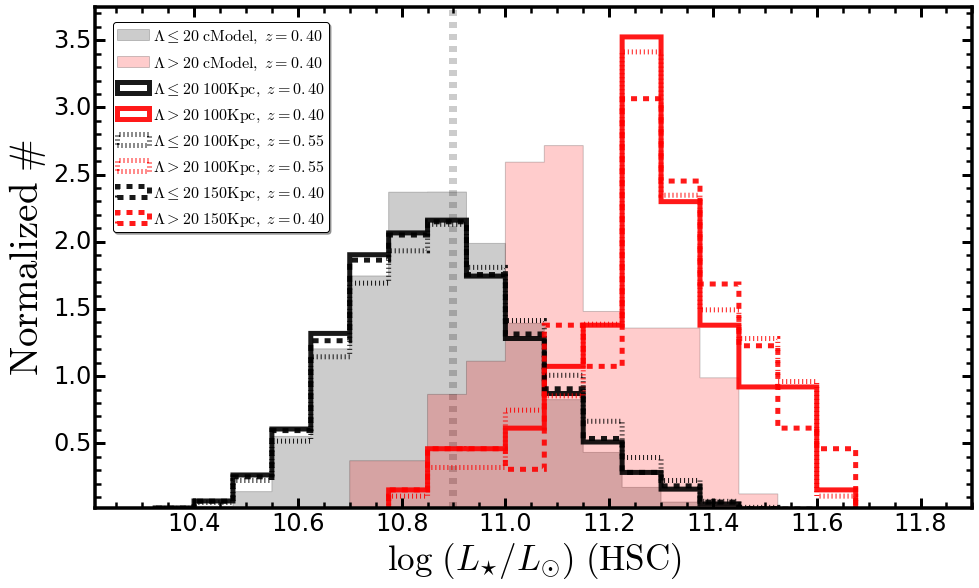

In [27]:
fig = plt.figure(figsize=(14, 8))
rec = [0.11, 0.12, 0.87, 0.87]
ax1 = plt.axes(rec)

ax1.axvline(10.9, linewidth=8.0, color='k', linestyle='--', 
            alpha=0.2, zorder=0)

# ---------------------------------------------------------------------------
# Histogram 
## cModel 
temp = ax1.hist(gamaZ1['lumI_cmodel'], bins=24, range=[10.1, 11.9], 
                orientation='vertical', histtype='stepfilled', 
                color='k', alpha=0.2, normed=1, 
                label='$\Lambda \leq 20\mathrm{\ cModel},\ z=0.40$')

temp = ax1.hist(bcgZ1['lumI_cmodel'], bins=24, range=[10.1, 11.9], 
                orientation='vertical', histtype='stepfilled', 
                color='r', alpha=0.2, normed=1, 
                label='$\Lambda > 20\mathrm{\ cModel},\ z=0.40$')

## SBP 100
temp = ax1.hist(gamaZ1['lum_100'], bins=24, range=[10.1, 11.9], linewidth=5.0,
                orientation='vertical', histtype='step', 
                color='k', alpha=0.9, normed=1, 
                label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.40$')

temp = ax1.hist(bcgZ1['lum_100'], bins=24, range=[10.1, 11.9], linewidth=5.0, 
                orientation='vertical', histtype='step', 
                color='r', alpha=0.9, normed=1, 
                label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.40$')

## SBP 100
temp = ax1.hist(gamaZ2['lum_100'], bins=24, range=[10.1, 11.9], linewidth=5.0,
                orientation='vertical', histtype='step', 
                color='k', alpha=0.9, normed=1, linestyle=':',
                label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.55$')

temp = ax1.hist(bcgZ2['lum_100'], bins=24, range=[10.1, 11.9], linewidth=5.0, 
                orientation='vertical', histtype='step', 
                color='r', alpha=0.9, normed=1, linestyle=':',
                label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.55$')

## SBP 150
temp = ax1.hist(gamaZ1['lum_150'], bins=24, range=[10.1, 11.9], linewidth=5.0,
                orientation='vertical', histtype='step', 
                color='k', alpha=0.9, normed=1, linestyle='--',
                label='$\Lambda \leq 20\mathrm{\ 150 Kpc},\ z=0.40$')

temp = ax1.hist(bcgZ1['lum_150'], bins=24, range=[10.1, 11.9], linewidth=5.0, 
                orientation='vertical', histtype='step', 
                color='r', alpha=0.9, normed=1, linestyle='--',
                label='$\Lambda > 20\mathrm{\ 150 Kpc},\ z=0.40$')

ax1.legend(loc=(0.02, 0.55), shadow=True, fancybox=True, 
           numpoints=1, fontsize=16, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

ax1.set_xlim(10.21, 11.9)
ax1.set_ylim(0.02, 3.75)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (L_{\star}/L_{\odot})\ \mathrm{(HSC)}$', size=35)
ax1.set_ylabel('$\mathrm{Normalized\ \#}$', size=39)

fig.savefig('../figure/hscMassive_lum_distri_norm.png', dpi=230)
plt.show()

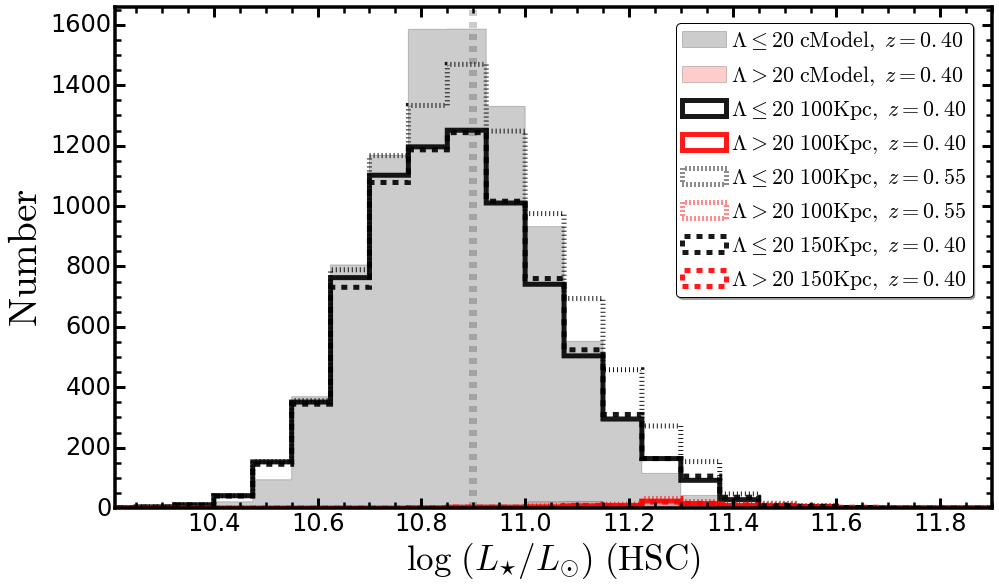

In [28]:
fig = plt.figure(figsize=(14, 8))
rec = [0.11, 0.12, 0.87, 0.87]
ax1 = plt.axes(rec)

ax1.axvline(10.9, linewidth=8.0, color='k', linestyle='--', 
            alpha=0.2, zorder=0)

# ---------------------------------------------------------------------------
# Histogram 
## cModel 
nGama1, bGama1, pGama1 = ax1.hist(gamaZ1['lumI_cmodel'], 
                                  bins=24, range=[10.1, 11.9], 
                                  orientation='vertical', histtype='stepfilled', 
                                  color='k', alpha=0.2, normed=0, 
                                  label='$\Lambda \leq 20\mathrm{\ cModel},\ z=0.40$')

nBcg1, bBcg1, pBcg1 = ax1.hist(bcgZ1['lumI_cmodel'], 
                               bins=24, range=[10.1, 11.9], 
                               orientation='vertical', histtype='stepfilled', 
                               color='r', alpha=0.2, normed=0, 
                               label='$\Lambda > 20\mathrm{\ cModel},\ z=0.40$')

## SBP 100
nGama2, bGama2, pGama2 = ax1.hist(gamaZ1['lum_100'], 
                                  bins=24, range=[10.1, 11.9], linewidth=5.0,
                                  orientation='vertical', histtype='step', 
                                  color='k', alpha=0.9, normed=0, 
                                  label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.40$')

nBcg2, bBcg2, pBcg2 = ax1.hist(bcgZ1['lum_100'], 
                               bins=24, range=[10.1, 11.9], linewidth=5.0, 
                               orientation='vertical', histtype='step', 
                               color='r', alpha=0.9, normed=0, 
                               label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.40$')

## SBP 100; up to z=0.55
nGama2b, bGama2b, pGama2b = ax1.hist(gamaZ2['lum_100'], 
                                     bins=24, range=[10.1, 11.9], linewidth=5.0,
                                     orientation='vertical', histtype='step', 
                                     color='k', alpha=0.9, normed=0, linestyle=':',
                                     label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.55$')

nBcg2b, bBcg2b, pBcg2b = ax1.hist(bcgZ2['lum_100'], 
                                  bins=24, range=[10.1, 11.9], linewidth=5.0, 
                                  orientation='vertical', histtype='step', 
                                  color='r', alpha=0.9, normed=0, linestyle=':',
                                  label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.55$')

## SBP 150
nGama3, bGama3, pGama3 = ax1.hist(gamaZ1['lum_150'], 
                                  bins=24, range=[10.1, 11.9], linewidth=5.0,
                                  orientation='vertical', histtype='step', 
                                  color='k', alpha=0.9, normed=0, linestyle='--',
                                  label='$\Lambda \leq 20\mathrm{\ 150 Kpc},\ z=0.40$')

nBcg3, bBcg3, pBcg3 = ax1.hist(bcgZ1['lum_150'], 
                               bins=24, range=[10.1, 11.9], linewidth=5.0, 
                               orientation='vertical', histtype='step', 
                               color='r', alpha=0.9, normed=0, linestyle='--',
                               label='$\Lambda > 20\mathrm{\ 150 Kpc},\ z=0.40$')

ax1.legend(loc=(0.64, 0.42), shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

ax1.set_xlim(10.21, 11.9)
ax1.set_ylim(1, 1660)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (L_{\star}/L_{\odot})\ \mathrm{(HSC)}$', size=35)
ax1.set_ylabel('$\mathrm{Number}$', size=39)

fig.savefig('../figure/hscMassive_lum_distri.png', dpi=230)
plt.show()

In [29]:
binSize = bGama1[1] - bGama1[0]
print(binSize)

dnGama1 = np.log10(nGama1 / (dGama1 * binSize))
dnBcg1 = np.log10(nBcg1 / (dBcg1 * binSize))

dnGama2 = np.log10(nGama2 / (dGama1 * binSize))
dnBcg2 = np.log10(nBcg2 / (dBcg1 * binSize))

dnGama3 = np.log10(nGama3 / (dGama1 * binSize))
dnBcg3 = np.log10(nBcg3 / (dBcg1 * binSize))

dnGama2b = np.log10(nGama2b / (dGama2 * binSize))
dnBcg2b = np.log10(nBcg2b / (dBcg2 * binSize))

0.075


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


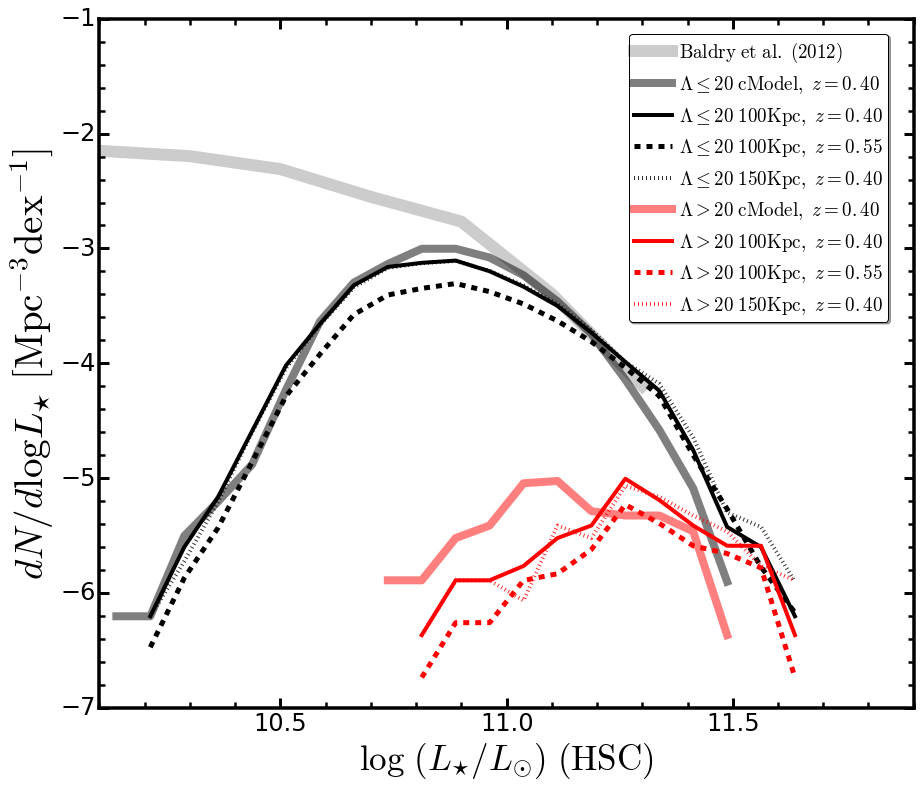

In [30]:
fig = plt.figure(figsize=(13, 11))
rec = [0.12, 0.12, 0.87, 0.87]
ax1 = plt.axes(rec)

#ax1.axvline(10.9, color='k', linewidth=8.0, alpha=0.4)

# Baldry+2012
ax1.plot(lfB12['col1'], np.log10(lfB12['col3']), c='k', linestyle='-', 
         linewidth=12.0, alpha=0.2, label='$\mathrm{Baldry\ et\ al.\ (2012)}$')

ax1.plot((bGama1[1:] + bGama1[0:-1])/2.0, dnGama1, c='k', 
         linewidth=8.0, label='$\Lambda \leq 20\mathrm{\ cModel},\ z=0.40$', 
         linestyle='-', alpha=0.5)

# GAMA
ax1.plot((bGama2[1:] + bGama2[0:-1])/2.0, dnGama2, c='k', 
         linewidth=4.0, label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.40$', 
         linestyle='-', alpha=1.0)

ax1.plot((bGama2b[1:] + bGama2b[0:-1])/2.0, dnGama2b, c='k', 
         linewidth=5.0, label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.55$', 
         linestyle='--')

ax1.plot((bGama3[1:] + bGama3[0:-1])/2.0, dnGama3, c='k', 
         linewidth=4.0, label='$\Lambda \leq 20\mathrm{\ 150 Kpc},\ z=0.40$', 
         linestyle=':', alpha=0.8)

# BCG
ax1.plot((bBcg1[1:] + bBcg1[0:-1])/2.0, dnBcg1, c='r', 
         linewidth=8.0, label='$\Lambda > 20\mathrm{\ cModel},\ z=0.40$', 
         linestyle='-', alpha=0.5)

ax1.plot((bBcg2[1:] + bBcg2[0:-1])/2.0, dnBcg2, c='r', 
         linewidth=4.0, label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.40$', 
         linestyle='-', alpha=1.0)

ax1.plot((bBcg2b[1:] + bBcg2b[0:-1])/2.0, dnBcg2b, c='r', 
         linewidth=5.0, label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.55$', 
         linestyle='--')

ax1.plot((bBcg3[1:] + bBcg3[0:-1])/2.0, dnBcg3, c='r', 
         linewidth=4.0, label='$\Lambda > 20\mathrm{\ 150 Kpc},\ z=0.40$', 
         linestyle=':', alpha=0.8)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.legend(loc=(0.65, 0.56), shadow=True, fancybox=True, 
           numpoints=1, fontsize=19, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.34)

#ax1.text(0.48, 0.88, '$\mathrm{FSPS\ SSP\ +\ Chabrier\ IMF}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

ax1.set_xlim(10.1, 11.9)
#ax1.set_ylim(-8.9, -5.51)

# Label
ax1.set_xlabel('$\log\ (L_{\star}/L_{\odot})\ \mathrm{(HSC)}$', size=35)
ax1.set_ylabel('$dN/d\logL_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=39)

fig.savefig('../figure/hscMassive_lum_function.png', dpi=230)

plt.show()

# Stellar Mass Function

In [31]:
mfB12 = Table.read('gsmf-B12.txt', format='ascii')

massArr = np.arange(7.0, 13.0, 0.1)

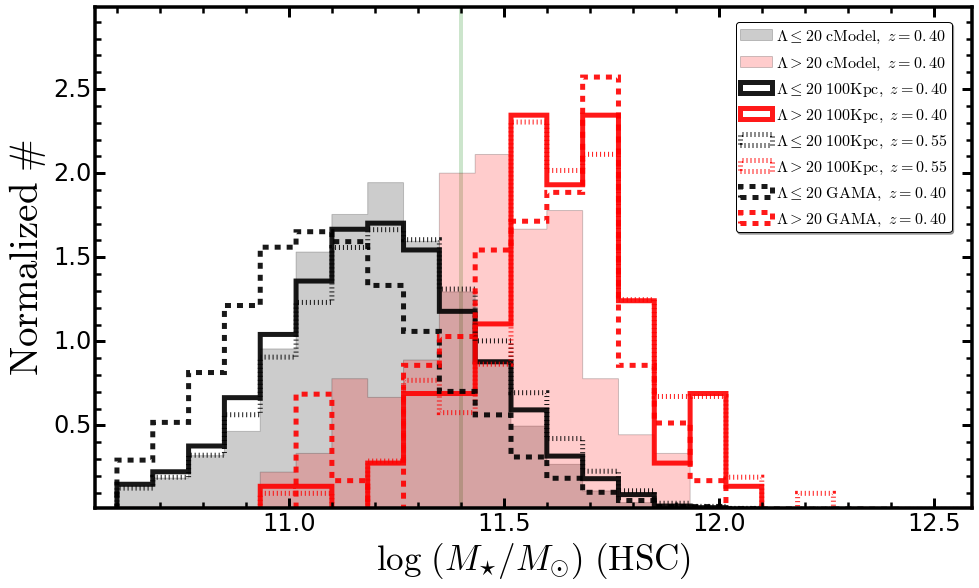

In [32]:
fig = plt.figure(figsize=(14, 8))
rec = [0.11, 0.12, 0.87, 0.87]
ax1 = plt.axes(rec)

ax1.axvline(11.4, linewidth=4.0, color='g', linestyle='-', 
            alpha=0.2, zorder=0)

# ---------------------------------------------------------------------------
# Histogram 
## cModel 
temp = ax1.hist(gamaZ1['lumI_cmodel'] + gamaZ1['logm2lI_C'], 
                bins=24, range=[10.6, 12.6], 
                orientation='vertical', histtype='stepfilled', 
                color='k', alpha=0.2, normed=1, 
                label='$\Lambda \leq 20\mathrm{\ cModel},\ z=0.40$')

temp = ax1.hist(bcgZ1['lumI_cmodel'] + bcgZ1['logm2lI_C'], 
                bins=24, range=[10.6, 12.6], 
                orientation='vertical', histtype='stepfilled', 
                color='r', alpha=0.2, normed=1, 
                label='$\Lambda > 20\mathrm{\ cModel},\ z=0.40$')

## SBP 100
temp = ax1.hist(gamaZ1['lum_100'] + gamaZ1['logm2lI_C'], 
                bins=24, range=[10.6, 12.6], linewidth=5.0,
                orientation='vertical', histtype='step', 
                color='k', alpha=0.9, normed=1, 
                label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.40$')

temp = ax1.hist(bcgZ1['lum_100'] + bcgZ1['logm2lI_C'], 
                bins=24, range=[10.6, 12.6], linewidth=5.0, 
                orientation='vertical', histtype='step', 
                color='r', alpha=0.9, normed=1, 
                label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.40$')

## SBP 100
temp = ax1.hist(gamaZ2['lum_100'] + gamaZ2['logm2lI_C'], 
                bins=24, range=[10.6, 12.6], linewidth=5.0,
                orientation='vertical', histtype='step', 
                color='k', alpha=0.9, normed=1, linestyle=':',
                label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.55$')

temp = ax1.hist(bcgZ2['lum_100'] + bcgZ2['logm2lI_C'], 
                bins=24, range=[10.6, 12.6], linewidth=5.0, 
                orientation='vertical', histtype='step', 
                color='r', alpha=0.9, normed=1, linestyle=':',
                label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.55$')

## GAMA
temp = ax1.hist(gamaZ1['logms_gama'] + np.log10(gamaZ1['fluxscale_gama']), 
                bins=24, range=[10.6, 12.6], linewidth=5.0,
                orientation='vertical', histtype='step', 
                color='k', alpha=0.9, normed=1, linestyle='--',
                label='$\Lambda \leq 20\mathrm{\ GAMA},\ z=0.40$')

temp = ax1.hist(bcgZ1['logms_gama'] + np.log10(bcgZ1['fluxscale_gama']), 
                bins=24, range=[10.6, 12.6], linewidth=5.0, 
                orientation='vertical', histtype='step', 
                color='r', alpha=0.9, normed=1, linestyle='--',
                label='$\Lambda > 20\mathrm{\ GAMA},\ z=0.40$')

ax1.legend(loc=(0.73, 0.55), shadow=True, fancybox=True, 
           numpoints=1, fontsize=16, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

ax1.set_xlim(10.55, 12.59)
ax1.set_ylim(0.01, 2.99)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ \mathrm{(HSC)}$', size=35)
ax1.set_ylabel('$\mathrm{Normalized\ \#}$', size=39)

fig.savefig('../figure/hscMassive_mass_distri_norm.png', dpi=230)
plt.show()

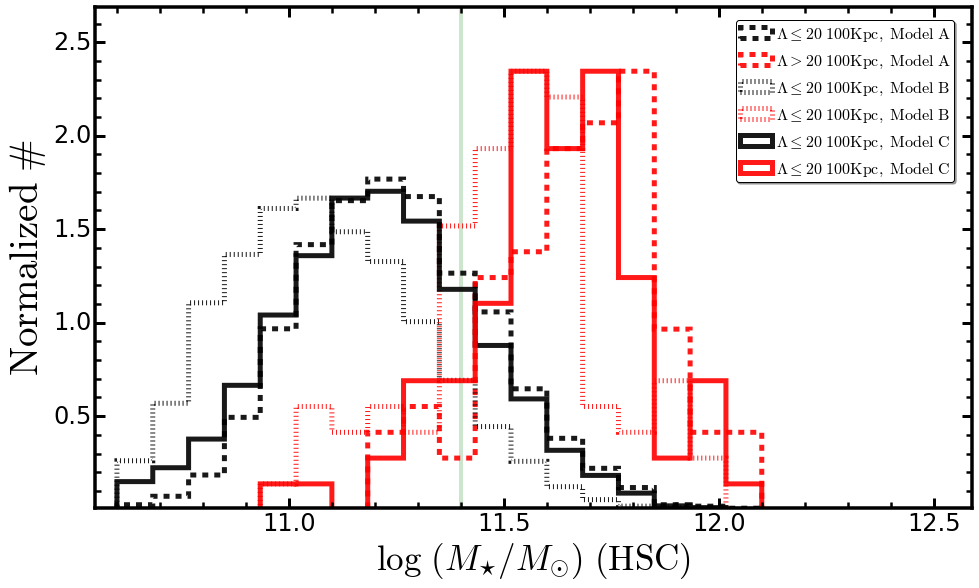

In [33]:
fig = plt.figure(figsize=(14, 8))
rec = [0.11, 0.12, 0.87, 0.87]
ax1 = plt.axes(rec)

ax1.axvline(11.4, linewidth=4.0, color='g', linestyle='-', 
            alpha=0.2, zorder=0)

# ---------------------------------------------------------------------------
# Histogram 
## SBP 100
temp = ax1.hist(gamaZ1['lum_100'] + gamaZ1['logm2lI_A'], 
                bins=24, range=[10.6, 12.6], linewidth=5.0,
                orientation='vertical', histtype='step', 
                color='k', alpha=0.9, normed=1, linestyle='--',
                label='$\Lambda \leq 20\mathrm{\ 100 Kpc,\ Model\ A}$')

temp = ax1.hist(bcgZ1['lum_100'] + bcgZ1['logm2lI_A'], 
                bins=24, range=[10.6, 12.6], linewidth=5.0, 
                orientation='vertical', histtype='step', 
                color='r', alpha=0.9, normed=1, linestyle='--',
                label='$\Lambda > 20\mathrm{\ 100 Kpc,\ Model\ A}$')

## SBP 100
temp = ax1.hist(gamaZ1['lum_100'] + gamaZ1['logm2lI_B'], 
                bins=24, range=[10.6, 12.6], linewidth=5.0,
                orientation='vertical', histtype='step', 
                color='k', alpha=0.9, normed=1, linestyle=':',
                label='$\Lambda \leq 20\mathrm{\ 100 Kpc,\ Model\ B}$')

temp = ax1.hist(bcgZ1['lum_100'] + bcgZ1['logm2lI_B'], 
                bins=24, range=[10.6, 12.6], linewidth=5.0, 
                orientation='vertical', histtype='step', 
                color='r', alpha=0.9, normed=1, linestyle=':',
                label='$\Lambda \leq 20\mathrm{\ 100 Kpc,\ Model\ B}$')

## SBP 100
temp = ax1.hist(gamaZ1['lum_100'] + gamaZ1['logm2lI_C'], 
                bins=24, range=[10.6, 12.6], linewidth=5.0,
                orientation='vertical', histtype='step', 
                color='k', alpha=0.9, normed=1, linestyle='-',
                label='$\Lambda \leq 20\mathrm{\ 100 Kpc,\ Model\ C}$')

temp = ax1.hist(bcgZ1['lum_100'] + bcgZ1['logm2lI_C'], 
                bins=24, range=[10.6, 12.6], linewidth=5.0, 
                orientation='vertical', histtype='step', 
                color='r', alpha=0.9, normed=1, linestyle='-',
                label='$\Lambda \leq 20\mathrm{\ 100 Kpc,\ Model\ C}$')


ax1.legend(loc=(0.73, 0.65), shadow=True, fancybox=True, 
           numpoints=1, fontsize=16, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

ax1.set_xlim(10.55, 12.59)
ax1.set_ylim(0.01, 2.69)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ \mathrm{(HSC)}$', size=35)
ax1.set_ylabel('$\mathrm{Normalized\ \#}$', size=39)

fig.savefig('../figure/hscMassive_mass_distri_norm_mod.png', dpi=230)
plt.show()

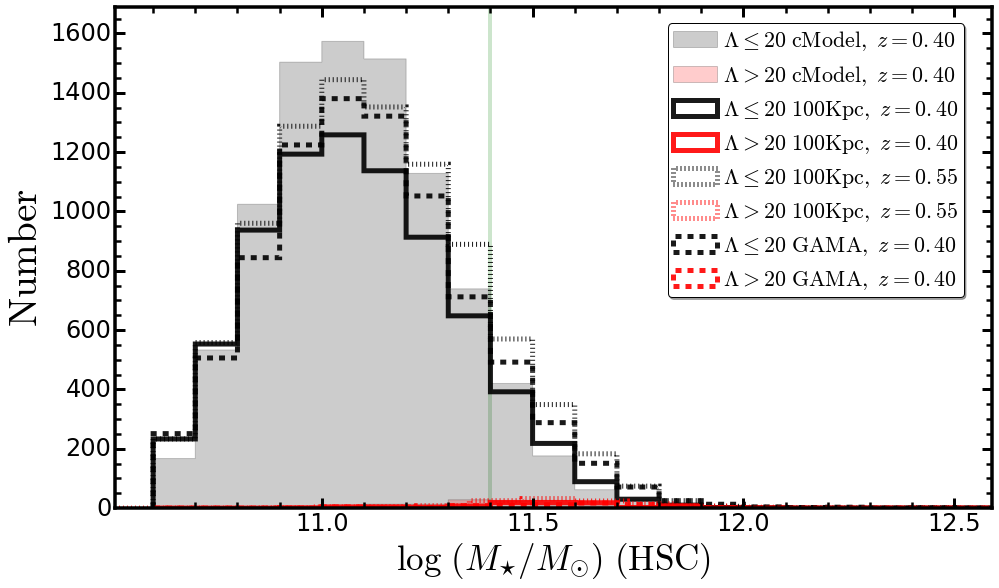

In [34]:
fig = plt.figure(figsize=(14, 8))
rec = [0.11, 0.12, 0.87, 0.87]
ax1 = plt.axes(rec)

ax1.axvline(11.4, linewidth=4.0, color='g', linestyle='-', 
            alpha=0.2, zorder=0)

# ---------------------------------------------------------------------------
# Histogram 
## cModel 
nGama1, bGama1, pGama1 = ax1.hist(gamaZ1['lumI_cmodel'] + gamaZ1['logm2lI_B'], 
                                  bins=20, range=[10.6, 12.6], 
                                  orientation='vertical', histtype='stepfilled', 
                                  color='k', alpha=0.2, normed=0, 
                                  label='$\Lambda \leq 20\mathrm{\ cModel},\ z=0.40$')

nBcg1, bBcg1, pBcg1 = ax1.hist(bcgZ1['lumI_cmodel'] + bcgZ1['logm2lI_B'], 
                               bins=20, range=[10.6, 12.6], 
                               orientation='vertical', histtype='stepfilled', 
                               color='r', alpha=0.2, normed=0, 
                               label='$\Lambda > 20\mathrm{\ cModel},\ z=0.40$')

## SBP 100
nGama2, bGama2, pGama2 = ax1.hist(gamaZ1['lum_100'] + gamaZ1['logm2lI_B'], 
                                  bins=20, range=[10.6, 12.6], linewidth=5.0,
                                  orientation='vertical', histtype='step', 
                                  color='k', alpha=0.9, normed=0, 
                                  label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.40$')

nBcg2, bBcg2, pBcg2 = ax1.hist(bcgZ1['lum_100'] + bcgZ1['logm2lI_B'], 
                               bins=20, range=[10.6, 12.6], linewidth=5.0, 
                               orientation='vertical', histtype='step', 
                               color='r', alpha=0.9, normed=0, 
                               label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.40$')

## SBP 100; up to z=0.55
nGama2b, bGama2b, pGama2b = ax1.hist(gamaZ2['lum_100'] + gamaZ2['logm2lI_B'], 
                                     bins=20, range=[10.6, 12.6], linewidth=5.0,
                                     orientation='vertical', histtype='step', 
                                     color='k', alpha=0.9, normed=0, linestyle=':',
                                     label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.55$')

nBcg2b, bBcg2b, pBcg2b = ax1.hist(bcgZ2['lum_100'] + bcgZ2['logm2lI_B'], 
                                  bins=20, range=[10.1, 12.6], linewidth=5.0, 
                                  orientation='vertical', histtype='step', 
                                  color='r', alpha=0.9, normed=0, linestyle=':',
                                  label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.55$')

## SBP 150
nGama3, bGama3, pGama3 = ax1.hist(gamaZ1['logms_gama'] + np.log10(gamaZ1['fluxscale_gama']), 
                                  bins=20, range=[10.6, 12.6], linewidth=5.0,
                                  orientation='vertical', histtype='step', 
                                  color='k', alpha=0.9, normed=0, linestyle='--',
                                  label='$\Lambda \leq 20\mathrm{\ GAMA},\ z=0.40$')

nBcg3, bBcg3, pBcg3 = ax1.hist(bcgZ1['logms_gama'] + np.log10(bcgZ1['fluxscale_gama']), 
                               bins=20, range=[10.6, 12.6], linewidth=5.0, 
                               orientation='vertical', histtype='step', 
                               color='r', alpha=0.9, normed=0, linestyle='--',
                               label='$\Lambda > 20\mathrm{\ GAMA},\ z=0.40$')

ax1.legend(loc=(0.63, 0.42), shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

ax1.set_xlim(10.51, 12.59)
ax1.set_ylim(1, 1690)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ \mathrm{(HSC)}$', size=35)
ax1.set_ylabel('$\mathrm{Number}$', size=39)

fig.savefig('../figure/hscMassive_mass_distri_modB.png', dpi=230)
plt.show()

In [35]:
binSize = bGama1[1] - bGama1[0]
print(binSize)

dnGama1 = np.log10(nGama1 / (dGama1 * binSize))
dnBcg1 = np.log10(nBcg1 / (dBcg1 * binSize))

dnGama2 = np.log10(nGama2 / (dGama1 * binSize))
dnBcg2 = np.log10(nBcg2 / (dBcg1 * binSize))

dnGama3 = np.log10(nGama3 / (dGama1 * binSize))
dnBcg3 = np.log10(nBcg3 / (dBcg1 * binSize))

dnGama2b = np.log10(nGama2b / (dGama2 * binSize))
dnBcg2b = np.log10(nBcg2b / (dBcg2 * binSize))

0.1


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


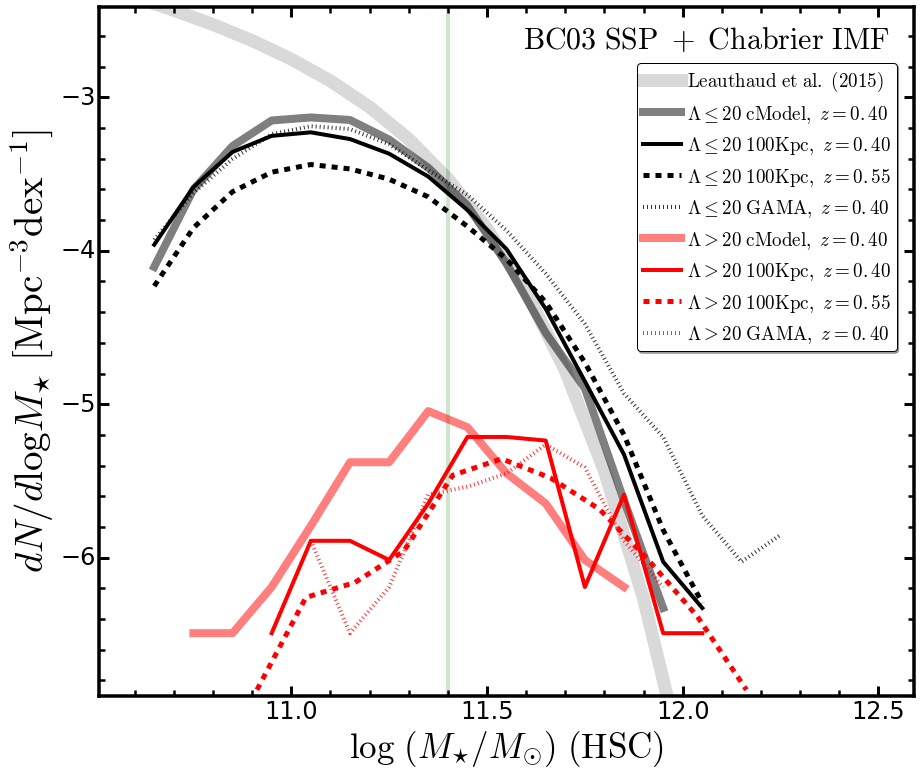

In [43]:
fig = plt.figure(figsize=(13, 11))
rec = [0.12, 0.12, 0.87, 0.87]
ax1 = plt.axes(rec)

ax1.axvline(11.4, linewidth=4.0, color='g', linestyle='-', 
            alpha=0.2, zorder=0)


# Baldry+2012
#ax1.plot(mfB12['col1'][:-2], np.log10(mfB12['col3'][:-2]) - 3.0, c='k', linestyle='-', 
#         linewidth=12.0, alpha=0.2, label='$\mathrm{Baldry\ et\ al.\ (2012)}$')

# Leauthaud+2015
ax1.plot(massArr, np.log10(doubleSchechter(massArr)), c='k',
         linestyle='-', linewidth=13.0, alpha=0.15, 
         label='$\mathrm{Leauthaud\ et\ al.\ (2015)}$')

# GAMA
ax1.plot((bGama1[1:] + bGama1[0:-1])/2.0, dnGama1, c='k', 
         linewidth=8.0, label='$\Lambda \leq 20\mathrm{\ cModel},\ z=0.40$', 
         linestyle='-', alpha=0.5)

ax1.plot((bGama2[1:] + bGama2[0:-1])/2.0, dnGama2, c='k', 
         linewidth=4.0, label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.40$', 
         linestyle='-', alpha=1.0)

ax1.plot((bGama2b[1:] + bGama2b[0:-1])/2.0, dnGama2b, c='k', 
         linewidth=5.0, label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.55$', 
         linestyle='--')

ax1.plot((bGama3[1:] + bGama3[0:-1])/2.0, dnGama3, c='k', 
         linewidth=4.0, label='$\Lambda \leq 20\mathrm{\ GAMA},\ z=0.40$', 
         linestyle=':', alpha=0.8)

# BCG
ax1.plot((bBcg1[1:] + bBcg1[0:-1])/2.0, dnBcg1, c='r', 
         linewidth=8.0, label='$\Lambda > 20\mathrm{\ cModel},\ z=0.40$', 
         linestyle='-', alpha=0.5)

ax1.plot((bBcg2[1:] + bBcg2[0:-1])/2.0, dnBcg2, c='r', 
         linewidth=4.0, label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.40$', 
         linestyle='-', alpha=1.0)

ax1.plot((bBcg2b[1:] + bBcg2b[0:-1])/2.0, dnBcg2b, c='r', 
         linewidth=5.0, label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.55$', 
         linestyle='--')

ax1.plot((bBcg3[1:] + bBcg3[0:-1])/2.0, dnBcg3, c='r', 
         linewidth=4.0, label='$\Lambda > 20\mathrm{\ GAMA},\ z=0.40$', 
         linestyle=':', alpha=0.8)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.legend(loc=(0.66, 0.50), shadow=True, fancybox=True, 
           numpoints=1, fontsize=19, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.34)

ax1.text(0.52, 0.93, '$\mathrm{BC03\ SSP\ +\ Chabrier\ IMF}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=30.0, transform=ax1.transAxes)

ax1.set_xlim(10.51, 12.59)
ax1.set_ylim(-6.9, -2.41)

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ \mathrm{(HSC)}$', size=35)
ax1.set_ylabel('$dN/d\logM_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=39)

fig.savefig('../figure/hscMassive_mass_function_modB.png', dpi=230)

plt.show()

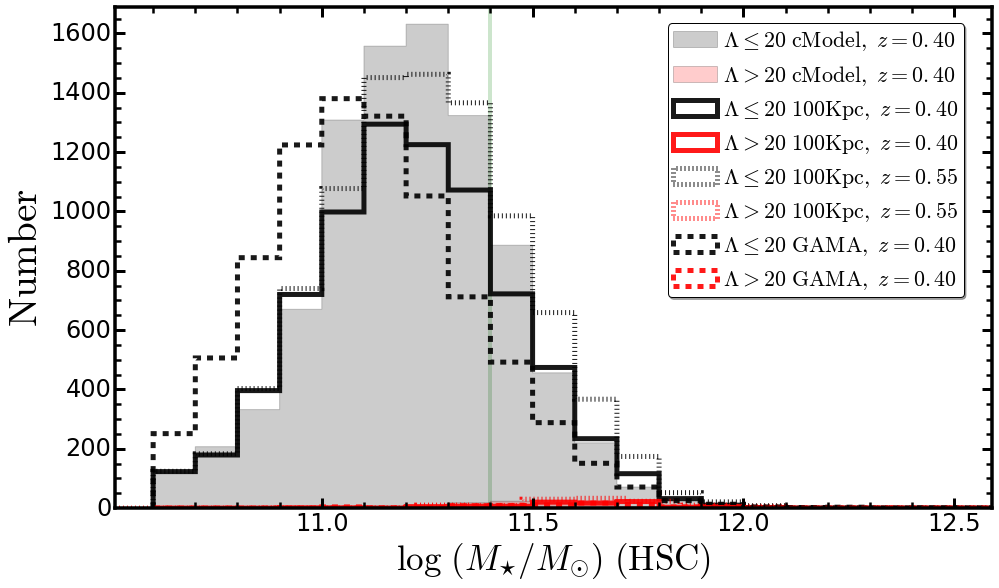

In [44]:
fig = plt.figure(figsize=(14, 8))
rec = [0.11, 0.12, 0.87, 0.87]
ax1 = plt.axes(rec)

ax1.axvline(11.4, linewidth=4.0, color='g', linestyle='-', 
            alpha=0.2, zorder=0)

# ---------------------------------------------------------------------------
# Histogram 
## cModel 
nGama1, bGama1, pGama1 = ax1.hist(gamaZ1['lumI_cmodel'] + gamaZ1['logm2lI_C'], 
                                  bins=20, range=[10.6, 12.6], 
                                  orientation='vertical', histtype='stepfilled', 
                                  color='k', alpha=0.2, normed=0, 
                                  label='$\Lambda \leq 20\mathrm{\ cModel},\ z=0.40$')

nBcg1, bBcg1, pBcg1 = ax1.hist(bcgZ1['lumI_cmodel'] + bcgZ1['logm2lI_C'], 
                               bins=20, range=[10.6, 12.6], 
                               orientation='vertical', histtype='stepfilled', 
                               color='r', alpha=0.2, normed=0, 
                               label='$\Lambda > 20\mathrm{\ cModel},\ z=0.40$')

## SBP 100
nGama2, bGama2, pGama2 = ax1.hist(gamaZ1['lum_100'] + gamaZ1['logm2lI_C'], 
                                  bins=20, range=[10.6, 12.6], linewidth=5.0,
                                  orientation='vertical', histtype='step', 
                                  color='k', alpha=0.9, normed=0, 
                                  label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.40$')

nBcg2, bBcg2, pBcg2 = ax1.hist(bcgZ1['lum_100'] + bcgZ1['logm2lI_C'], 
                               bins=20, range=[10.6, 12.6], linewidth=5.0, 
                               orientation='vertical', histtype='step', 
                               color='r', alpha=0.9, normed=0, 
                               label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.40$')

## SBP 100; up to z=0.55
nGama2b, bGama2b, pGama2b = ax1.hist(gamaZ2['lum_100'] + gamaZ2['logm2lI_C'], 
                                     bins=20, range=[10.6, 12.6], linewidth=5.0,
                                     orientation='vertical', histtype='step', 
                                     color='k', alpha=0.9, normed=0, linestyle=':',
                                     label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.55$')

nBcg2b, bBcg2b, pBcg2b = ax1.hist(bcgZ2['lum_100'] + bcgZ2['logm2lI_C'], 
                                  bins=20, range=[10.1, 12.6], linewidth=5.0, 
                                  orientation='vertical', histtype='step', 
                                  color='r', alpha=0.9, normed=0, linestyle=':',
                                  label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.55$')

## SBP 150
nGama3, bGama3, pGama3 = ax1.hist(gamaZ1['logms_gama'] + np.log10(gamaZ1['fluxscale_gama']), 
                                  bins=20, range=[10.6, 12.6], linewidth=5.0,
                                  orientation='vertical', histtype='step', 
                                  color='k', alpha=0.9, normed=0, linestyle='--',
                                  label='$\Lambda \leq 20\mathrm{\ GAMA},\ z=0.40$')

nBcg3, bBcg3, pBcg3 = ax1.hist(bcgZ1['logms_gama'] + np.log10(bcgZ1['fluxscale_gama']), 
                               bins=20, range=[10.6, 12.6], linewidth=5.0, 
                               orientation='vertical', histtype='step', 
                               color='r', alpha=0.9, normed=0, linestyle='--',
                               label='$\Lambda > 20\mathrm{\ GAMA},\ z=0.40$')

ax1.legend(loc=(0.63, 0.42), shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

ax1.set_xlim(10.51, 12.59)
ax1.set_ylim(1, 1690)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ \mathrm{(HSC)}$', size=35)
ax1.set_ylabel('$\mathrm{Number}$', size=39)

fig.savefig('../figure/hscMassive_mass_distri.png', dpi=230)
plt.show()

In [45]:
binSize = bGama1[1] - bGama1[0]
print(binSize)

dnGama1 = np.log10(nGama1 / (dGama1 * binSize))
dnBcg1 = np.log10(nBcg1 / (dBcg1 * binSize))

dnGama2 = np.log10(nGama2 / (dGama1 * binSize))
dnBcg2 = np.log10(nBcg2 / (dBcg1 * binSize))

dnGama3 = np.log10(nGama3 / (dGama1 * binSize))
dnBcg3 = np.log10(nBcg3 / (dBcg1 * binSize))

dnGama2b = np.log10(nGama2b / (dGama2 * binSize))
dnBcg2b = np.log10(nBcg2b / (dBcg2 * binSize))

0.1


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


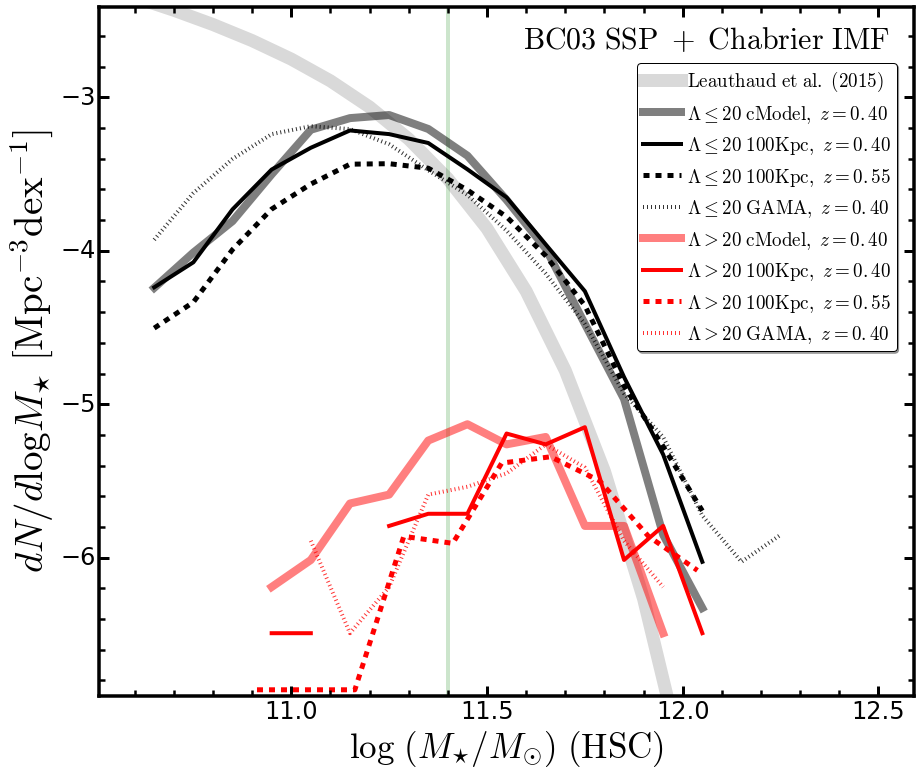

In [47]:
fig = plt.figure(figsize=(13, 11))
rec = [0.12, 0.12, 0.87, 0.87]
ax1 = plt.axes(rec)

ax1.axvline(11.4, linewidth=4.0, color='g', linestyle='-', 
            alpha=0.2, zorder=0)


# Baldry+2012
#ax1.plot(mfB12['col1'][:-2], np.log10(mfB12['col3'][:-2]) - 3.0, c='k', linestyle='-', 
#         linewidth=12.0, alpha=0.2, label='$\mathrm{Baldry\ et\ al.\ (2012)}$')

# Leauthaud+2015
ax1.plot(massArr, np.log10(doubleSchechter(massArr)), c='k',
         linestyle='-', linewidth=13.0, alpha=0.15, 
         label='$\mathrm{Leauthaud\ et\ al.\ (2015)}$')

# GAMA
ax1.plot((bGama1[1:] + bGama1[0:-1])/2.0, dnGama1, c='k', 
         linewidth=8.0, label='$\Lambda \leq 20\mathrm{\ cModel},\ z=0.40$', 
         linestyle='-', alpha=0.5)

ax1.plot((bGama2[1:] + bGama2[0:-1])/2.0, dnGama2, c='k', 
         linewidth=4.0, label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.40$', 
         linestyle='-', alpha=1.0)

ax1.plot((bGama2b[1:] + bGama2b[0:-1])/2.0, dnGama2b, c='k', 
         linewidth=5.0, label='$\Lambda \leq 20\mathrm{\ 100 Kpc},\ z=0.55$', 
         linestyle='--')

ax1.plot((bGama3[1:] + bGama3[0:-1])/2.0, dnGama3, c='k', 
         linewidth=4.0, label='$\Lambda \leq 20\mathrm{\ GAMA},\ z=0.40$', 
         linestyle=':', alpha=0.8)

# BCG
ax1.plot((bBcg1[1:] + bBcg1[0:-1])/2.0, dnBcg1, c='r', 
         linewidth=8.0, label='$\Lambda > 20\mathrm{\ cModel},\ z=0.40$', 
         linestyle='-', alpha=0.5)

ax1.plot((bBcg2[1:] + bBcg2[0:-1])/2.0, dnBcg2, c='r', 
         linewidth=4.0, label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.40$', 
         linestyle='-', alpha=1.0)

ax1.plot((bBcg2b[1:] + bBcg2b[0:-1])/2.0, dnBcg2b, c='r', 
         linewidth=5.0, label='$\Lambda > 20\mathrm{\ 100 Kpc},\ z=0.55$', 
         linestyle='--')

ax1.plot((bBcg3[1:] + bBcg3[0:-1])/2.0, dnBcg3, c='r', 
         linewidth=4.0, label='$\Lambda > 20\mathrm{\ GAMA},\ z=0.40$', 
         linestyle=':', alpha=0.8)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.legend(loc=(0.66, 0.50), shadow=True, fancybox=True, 
           numpoints=1, fontsize=19, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.34)

ax1.text(0.52, 0.93, '$\mathrm{BC03\ SSP\ +\ Chabrier\ IMF}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=30.0, transform=ax1.transAxes)

ax1.set_xlim(10.51, 12.59)
ax1.set_ylim(-6.9, -2.41)

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ \mathrm{(HSC)}$', size=35)
ax1.set_ylabel('$dN/d\logM_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=39)

fig.savefig('../figure/hscMassive_mass_function.png', dpi=230)

plt.show()